In [14]:
###Import
import sys

#import geobayes_simple as gs
from matplotlib import pyplot as plt
from IPython.core.display import Image

%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from IPython.core.pylabtools import figsize
figsize(10, 3)
import seaborn
seaborn.set_context(font_scale=2)
seaborn.set_style("white")

from pymc import graph

import scipy.optimize as sop
import scipy.stats as stats

### Simple 1-dimensional reservoir case: Modelling reservoir and seal

- abstract 1D case allows for a straightforward way to develop a preliminary and simplified model of a reservoir and respectively the development of a loss function
- here: 3 layer-interfaces model inherited from the work by De la Varga (2016) with adaptions made to represent a very abstract but in that way reasonable model of a reservoir system
- this case assumes the two layers of interest to form a petroleum system consisting of reservoir and seal in the subsurface
- very simplified and abstract just to illustrate the fundamental approach of this work

In [2]:
###Distributions for boundary locations
alpha = pm.Normal("alpha", -2000, 1./np.square(7.), value= 5)
beta = pm.Normal("beta", -2050, 1./np.square(25), value=-500)
gamma = pm.Normal("gamma", -2200, 1./np.square(45), value = 0)

###Model
model = pm.Model([alpha, beta, gamma])

In [3]:
###PyMC simulation
M = pm.MCMC(model)
M.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.7 sec

In [4]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

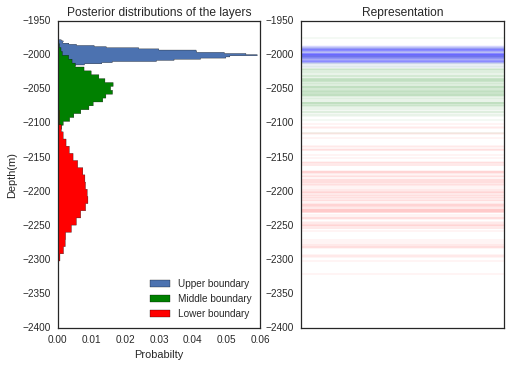

In [5]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Upper boundary", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Middle boundary", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Lower boundary", normed=True, color = "r", orientation="horizontal")

ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_ylim([-2400,-1950])
ax[0].set_xlabel("Probabilty")

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)
for i in range(100):
    ax[1].axhline(alpha_samples_all[i], alpha = 0.05)
    ax[1].axhline(beta_samples_all[i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all[i],c = "r", alpha = 0.05)

- describe the case referencing the figure above

In [ ]:
seal_thickness = (alpha_samples_all - beta_samples_all)
reservoir_thickness = (beta_samples_all - gamma_samples_all)
reservoir_depth = beta_samples_all

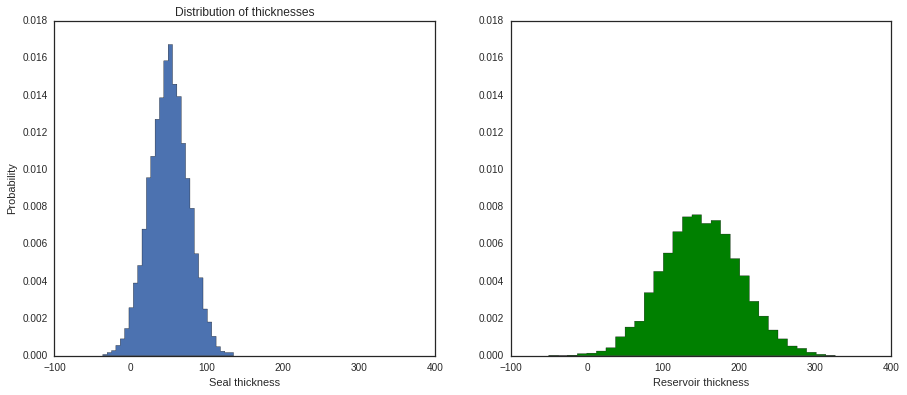

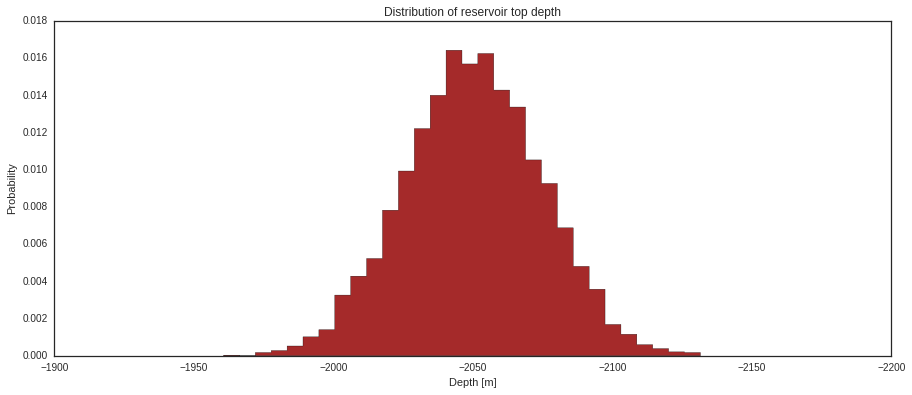

In [9]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)

ax[0].hist(seal_thickness, histtype='stepfilled', bins=30, alpha=1,
    label="Seal", normed=True)
ax[1].hist(reservoir_thickness, histtype='stepfilled', bins=30, alpha=1,
    label="Reservoir", normed=True, color = "g")

ax[0].set_title(r"""Distribution of thicknesses""")
ax[0].set_ylabel("Probability")
ax[0].set_xlabel("Seal thickness")
ax[1].set_xlabel("Reservoir thickness")
ax[0].set_xlim([-100,400])
ax[1].set_xlim([-100,400])
ax[0].set_ylim([0,0.018])
ax[1].set_ylim([0,0.018])

fig, ax = plt.subplots(1, 1)
plt.hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Reservoir Depth", normed=True, color = "brown")

ax.set_title(r"""Distribution of reservoir top depth""")
ax.set_ylabel("Probability")
ax.set_xlabel("Depth [m]")
ax.set_xlim([-1900,-2200])
ax.set_ylim([0,0.018]);

- relevant uncertain parameters in the model
- explain how they affect the score/value/quality of the reservoir

In [16]:
#MCMC with 2 inputs: reservoir thickness and depth
th_v = 20 #value per meter reservoir thickness
dp_c = 1  #cost per meter depth

res_top = pm.Normal("res_top", -2050, 1./np.square(25), value=-500)
res_bottom = pm.Normal("res_bottom", -2200, 1./np.square(45), value = 0)

@pm.deterministic
def res_thickness(res_top=res_top, res_bottom=res_bottom):
    return np.abs(res_top - res_bottom)

@pm.deterministic
def true_score(res_thickness=res_thickness, res_depth=res_top, th_v=th_v, dp_c=dp_c):
    return th_v * res_thickness + (dp_c * res_depth) 

model = pm.Model([true_score, res_thickness, res_top, res_bottom])

M = pm.MCMC(model)
M.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.8 sec

In [17]:
res_th_samples1 = M.trace("res_thickness")[:]
res_dp_samples1 = M.trace("res_top")[:]
res_bt_samples1 = M.trace("res_bottom")[:]
res_score_samples1 = M.trace("true_score")[:]

Portion of cases in which the score is negative: 0.173
Mean of posterior distribution: 980.958797547
Median of posterior distribution: 979.05182153


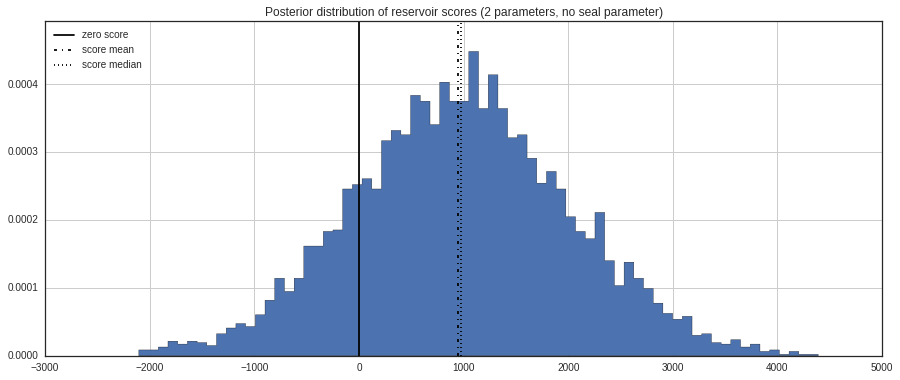

In [294]:
figsize(15, 6)

_hist = plt.hist(res_score_samples1, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of reservoir scores (2 parameters, no seal parameter)")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score",
           linestyles="-")
plt.vlines(res_quality_samples1.mean(), 0, 1.1 * np.max(_hist[0]),
           label="score mean", linestyles="-.")
plt.vlines(np.median(res_score_samples1), 0, 1.1 * np.max(_hist[0]),
           label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

negative_cases1 = (res_score_samples1<0).sum()/5000
print("Portion of cases in which the score is negative:",negative_cases1)
print("Mean of posterior distribution:",res_score_samples1.mean())
print("Median of posterior distribution:",np.median(res_score_samples1))

- describe modelling process 
- first only 2 parameters:
    - distribution of scores defined by reservoir thickness (positive) and reservoir depth (negative)
    - score as an abstract numerical valuation of the reservoir (not monetary, very simplified)

In [52]:
seal_top = pm.Normal("seal_top", -2000, 1./np.square(7.))
seal_to = 20 #Minimum treshold for seal to be safe

@pm.deterministic
def score_if_seal(res_thickness=res_thickness, res_depth=res_top, \
                  th_v=th_v, dp_c=dp_c):
    return (th_v * res_thickness + (dp_c * res_depth))

@pm.deterministic
def true_score2(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_depth=res_top, 
                 score_if_seal = score_if_seal):
    seal_th = seal_top - res_top
    if seal_th >= seal_to:
        x = score_if_seal
    else:
        x = (dp_c * res_depth)
    return x


model2 = pm.Model([true_score2, res_thickness, score_if_seal, res_top, res_bottom, seal_top])

M2 = pm.MCMC(model2)
M2.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.9 sec

In [53]:
M2.trace("true_score2")[:]
res_th_samples2 = M2.trace("res_thickness")[:]
seal_tp_samples2 = M2.trace("seal_top")[:]
res_tp_samples2 = M2.trace("res_top")[:]
res_dp_samples2 = M2.trace("res_top")[:]
res_bt_samples2 = M2.trace("res_bottom")[:]
res_score_samples2 = M2.trace("true_score2")[:]

Portion of cases in which the score is negative: 0.296
Mean of posterior distribution: 492.278253509
Median of posterior distribution: 665.138823225


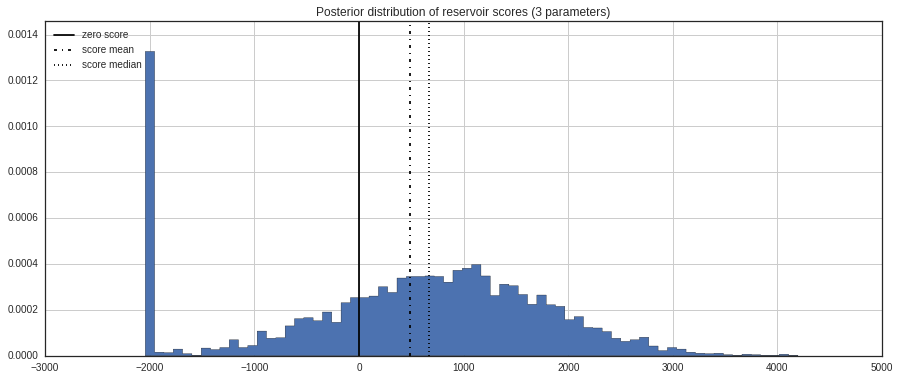

In [293]:
figsize(15, 6)

_hist = plt.hist(res_score_samples2, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of reservoir scores (3 parameters)")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score",
           linestyles="-")
plt.vlines(res_score_samples2.mean(), 0, 1.1 * np.max(_hist[0]),
           label="score mean", linestyles="-.")
plt.vlines(np.median(res_score_samples2), 0, 1.1 * np.max(_hist[0]),
           label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

negative_cases2 = (res_score_samples2<0).sum()/5000
print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution:",res_score_samples2.mean())
print("Median of posterior distribution:",np.median(res_score_samples2))

- model including seal reliability as a third parameter
- explain "seal failure" cases score
- distribution comparable to before, but now high concentration of "seal failure" cases
- increase in negative scores and significant shift of mean to the "left"

### Designing the loss function
- case: interest to estimate the reservoir score as precisely as possible or rather: to find the least bad estimate of the true value of the score
- disregarding subjective preferences and weight by an individual actor (decision maker), standard symmetric loss functions can be applied to find the objectively most precise estimate
- see absolute loss and squared loss functions

In [267]:
res_score = res_score_samples2
#seal_quality2 = seal_tp_samples2 - res_tp_samples2
estimates_s = np.arange(-5000,5000,50)

In [268]:
#I  - STANDARD LOSS FUNCTIONS
#Ia - Symmetric absolute loss function
def abs_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
def abs_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])
        return loss_s

#Symmetric absolute loss for one given value
def simple_abs_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)
        return loss_s
    
#Ib - Symmetric squared loss function
def sqr_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)**2
        loss_s[overest] = (estimate_s - true_s[overest])**2
        return loss_s
    
def sqr_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])**2
        return loss_s
    
#Symmetric squared loss for one given value
def simple_sqr_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)**2
        return loss_s

In [269]:
given_score1=-750
given_score2=0
given_score3=750

expected_absloss_s1 = lambda estimate_s: simple_abs_loss(estimate_s, given_score1)
expected_absloss_s2 = lambda estimate_s: simple_abs_loss(estimate_s, given_score2)
expected_absloss_s3 = lambda estimate_s: simple_abs_loss(estimate_s, given_score3)

expected_sqrloss_s1 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score1)
expected_sqrloss_s2 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score2)
expected_sqrloss_s3 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score3)

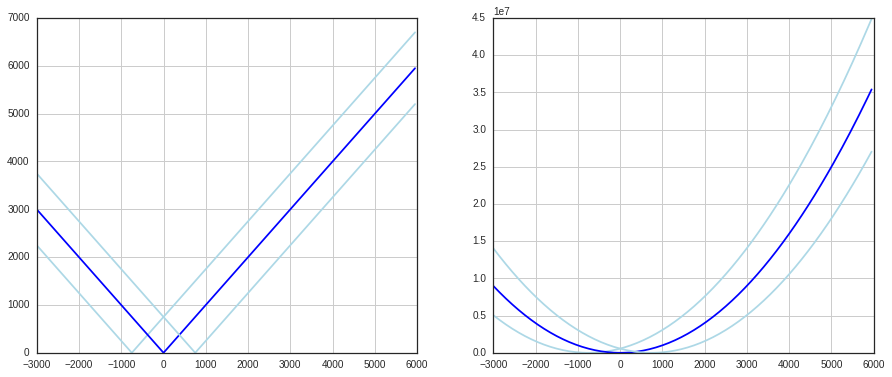

In [347]:
figsize(15, 6)
fig, ax = plt.subplots(1, 2)
ax[0].grid()
ax[1].grid()

#absolute
absloss = [expected_absloss_s1(e) for e in estimates_s]
ax[0].plot(estimates_s, absloss, color = 'lightblue')

absloss = [expected_absloss_s2(e) for e in estimates_s]
ax[0].plot(estimates_s, absloss, color = 'blue')

absloss = [expected_absloss_s3(e) for e in estimates_s]
ax[0].plot(estimates_s, absloss, color = 'lightblue')

#squared
sqrloss = [expected_sqrloss_s1(e) for e in estimates_s]
ax[1].plot(estimates_s, sqrloss, color = 'lightblue')

sqrloss = [expected_sqrloss_s2(e) for e in estimates_s]
ax[1].plot(estimates_s, sqrloss, color = 'blue')

sqrloss = [expected_sqrloss_s3(e) for e in estimates_s]
ax[1].plot(estimates_s, sqrloss, color = 'lightblue');

In [271]:
estimates_s = np.arange(-3000,6000,50)

Bayes action (min. expected loss) using absolute loss: 665
Bayes action (min. expected loss) using squared loss: 492


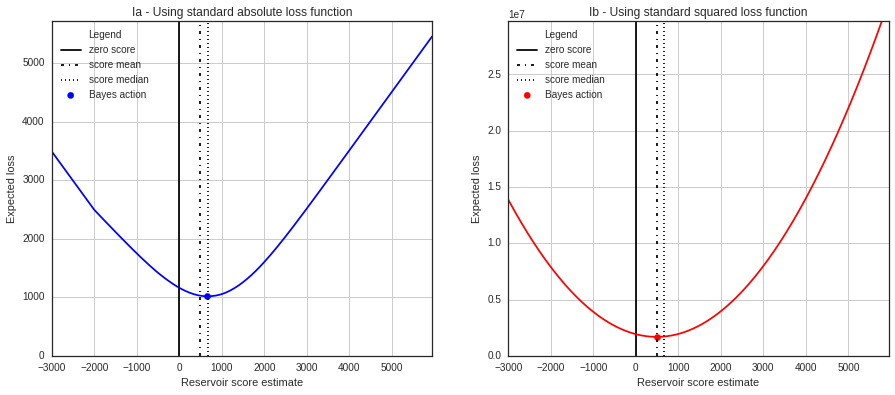

In [348]:
figsize(15, 6)
fig, ax = plt.subplots(1, 2)

ax[0].grid()
ax[0].vlines(0, 0, 1.1 * np.max(absloss), label="zero score", linestyles="-")
ax[0].vlines(res_score.mean(), 0, 1.1 * np.max(absloss), label="score mean", linestyles="-.")
ax[0].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(absloss), label="score median", linestyles=":")
ax[0].set_xlabel("Reservoir score estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_title("Ia - Using standard absolute loss function")
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(absloss))

ax[1].grid()
ax[1].vlines(0, 0, 1.1 * np.max(sqrloss), label="zero score", linestyles="-")
ax[1].vlines(res_score.mean(), 0, 1.1 * np.max(sqrloss), label="score mean", linestyles="-.")
ax[1].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(sqrloss), label="score median", linestyles=":")
ax[1].set_xlabel("Reservoir score estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_title("Ib - Using standard squared loss function")
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(sqrloss))

#Expected absolute loss
expected_abs_loss = lambda estimate_s: abs_loss(estimate_s, res_score).mean()
absloss = [expected_abs_loss(e) for e in estimates_s]
ax[0].plot(estimates_s, absloss, color = 'blue')
_min_absloss = sop.fmin(expected_abs_loss, 40,disp = False)
ax[0].scatter(_min_absloss, np.min(absloss), s = 40, color = 'blue', label = "Bayes action")
print("Bayes action (min. expected loss) using absolute loss: %d" % (_min_absloss))

#Expected squared loss
expected_sqr_loss = lambda estimate_s: sqr_loss(estimate_s, res_score).mean()
sqrloss = [expected_sqr_loss(e) for e in estimates_s]
ax[1].plot(estimates_s, sqrloss, color = 'red')
_min_sqrloss = sop.fmin(expected_sqr_loss, 40,disp = False)
ax[1].scatter(_min_sqrloss, np.min(sqrloss), s = 40, color = 'red', label = "Bayes action")
print("Bayes action (min. expected loss) using squared loss: %d" % (_min_sqrloss))

ax[0].legend(loc="upper left", scatterpoints=1, title="Legend");
ax[1].legend(loc="upper left", scatterpoints=1, title="Legend");

In [356]:
#II - Variations of asymmetric absolute loss function

#IIa - Adaption: Underestimation and overestimation irrelevant if both negative (Introducing irrelevant cases)
def res_score_loss1(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
#IIa - Adaption: Overestimation worse than underestimation
def res_score_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*2
        return loss_s    
    
#IIc - Adaption: Introducing "worst" overestimation
def res_score_loss3(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*2
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*4
        return loss_s
    
#IId - Adaption: Introducing "worst" underestimation
def res_score_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        loss_s[overest] = (estimate_s - true_s[overest])*2
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*4
        return loss_s
    
#IIr - Introducing risk
def res_score_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        #underest_good = estimate_s < true_s and true_s <= 0
        overest = (estimate_s > true_s) & (true_s >= 0) #and true_s >= 0
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        #overest_good = estimate_s > true_s and estimate_s <= 0
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        #loss_s[underest_good] = 0
        loss_s[overest] = (estimate_s - true_s[overest])*(risk_s/risks_s[2])
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(risk_s/(risks_s[2]*0.7))
        #loss_q[overest_good] = 0
        return loss_s

Portion of cases in which the score is negative: 0.296
Mean of posterior distribution: 492
Median of posterior distribution: 665.138823225
Bayes action (min. expected loss): 665


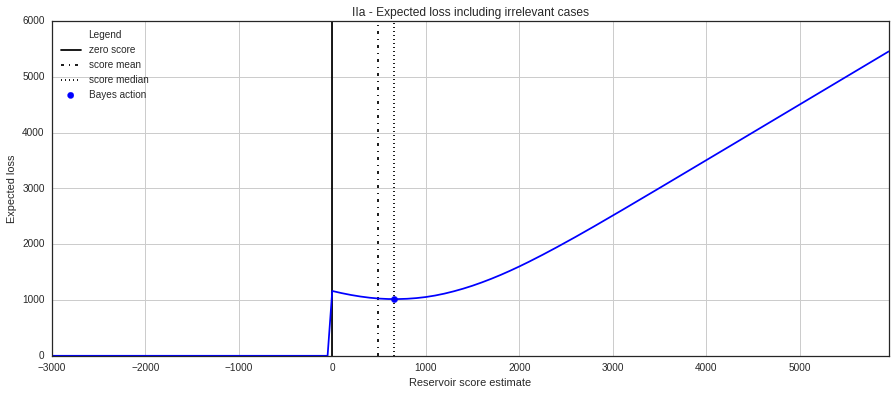

In [352]:
figsize(15, 6)
  
expected_loss_s = lambda estimate_s: res_score_loss1(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss = sop.fmin(expected_loss_s, 40, disp = False)
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.plot(estimates_s, loss, color = 'blue')
plt.scatter(_min_loss, expected_loss_s(_min_loss), s = 40, color = 'blue', label = "Bayes action")
#plt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")

print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution: %d" % (res_score.mean()))  
print("Median of posterior distribution:",np.median(res_score))
print("Bayes action (min. expected loss): %d" % (_min_loss))
    
plt.title("""IIa - Expected loss including irrelevant cases""")    
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()
plt.legend(loc="upper left", scatterpoints=1, title="Legend");

Portion of cases in which the score is negative: 0.296
Mean of posterior distribution: 492
Median of posterior distribution: 665.138823225
Bayes action (min. expected loss): 145


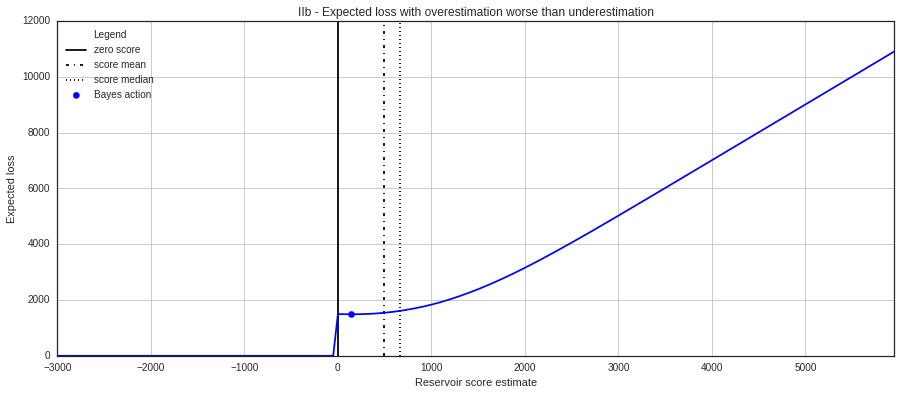

In [354]:
figsize(15, 6)
  
expected_loss_s = lambda estimate_s: res_score_loss2(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss = sop.fmin(expected_loss_s, 40, disp = False)
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.plot(estimates_s, loss, color = 'blue')
plt.scatter(_min_loss, expected_loss_s(_min_loss), s = 40, color = 'blue', label = "Bayes action")
#plt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")

print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution: %d" % (res_score.mean()))  
print("Median of posterior distribution:",np.median(res_score))
print("Bayes action (min. expected loss): %d" % (_min_loss))
    
plt.title("""IIb - Expected loss with overestimation worse than underestimation""")    
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()
plt.legend(loc="upper left", scatterpoints=1, title="Legend");

Portion of cases in which the score is negative: 0.296
Mean of posterior distribution: 492
Median of posterior distribution: 665.138823225
Bayes action (min. expected loss): -4


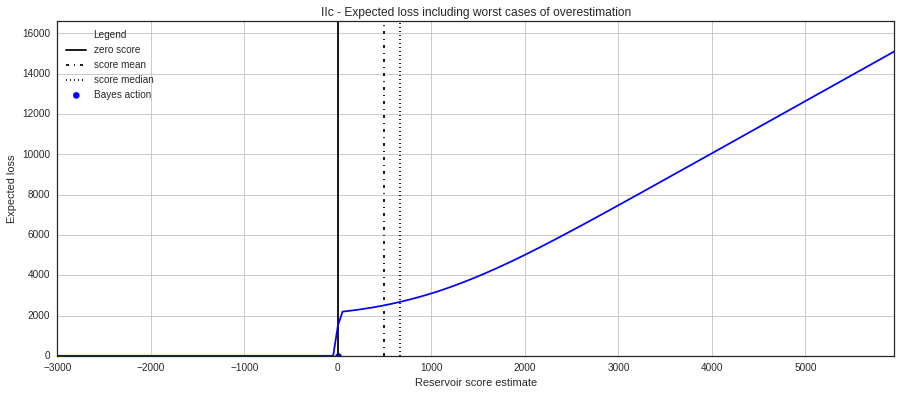

In [355]:
figsize(15, 6)
  
expected_loss_s = lambda estimate_s: res_score_loss3(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss = sop.fmin(expected_loss_s, 40, disp = False)
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.plot(estimates_s, loss, color = 'blue')
plt.scatter(_min_loss, expected_loss_s(_min_loss), s = 40, color = 'blue', label = "Bayes action")
#plt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")

print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution: %d" % (res_score.mean()))  
print("Median of posterior distribution:",np.median(res_score))
print("Bayes action (min. expected loss): %d" % (_min_loss))
    
plt.title("""IIc - Expected loss including worst cases of overestimation""")    
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()
plt.legend(loc="upper left", scatterpoints=1, title="Legend");

Portion of cases in which the score is negative: 0.296
Mean of posterior distribution: 492
Median of posterior distribution: 665.138823225
Bayes action (min. expected loss): -4


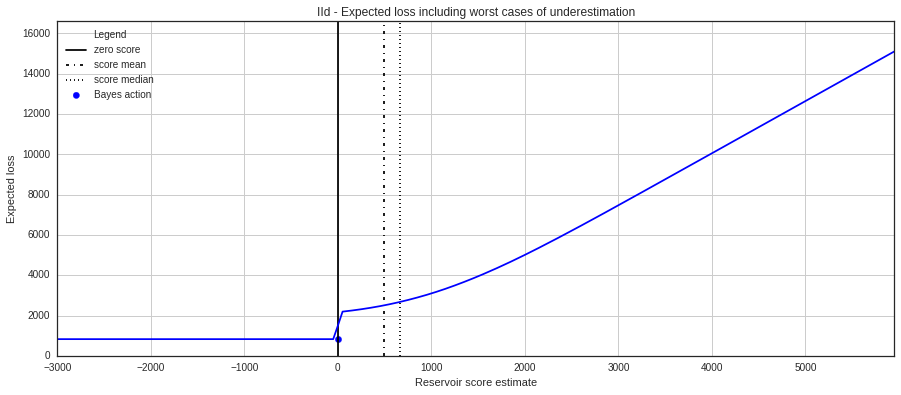

In [357]:
figsize(15, 6)
  
expected_loss_s = lambda estimate_s: res_score_loss4(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss = sop.fmin(expected_loss_s, 40, disp = False)
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.plot(estimates_s, loss, color = 'blue')
plt.scatter(_min_loss, expected_loss_s(_min_loss), s = 40, color = 'blue', label = "Bayes action")
#plt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")

print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution: %d" % (res_score.mean()))  
print("Median of posterior distribution:",np.median(res_score))
print("Bayes action (min. expected loss): %d" % (_min_loss))
    
plt.title("""IId - Expected loss including worst cases of underestimation""")    
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()
plt.legend(loc="upper left", scatterpoints=1, title="Legend");